# Supplemental Information
## Absorption Mode FT-IM Process
### Python Implementation -- Clowers and Sanders, 2021

--------------------------------------

## Module Imports 
* numpy
* matplotlib
* pandas
* scipy
* pyteomics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob, os

from scipy import signal
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from pyteomics import ms1, mzml

Establish default plotting parameters

In [2]:
plt.rcParams['figure.figsize'] = [16,5]

### Processing Functions

In [3]:
def DFT_data(time, amp, window='hanning', padLen = 0.5, minBool=False, windowBool = False, padBool = False):
    '''
    Performs necessary steps to carry out a discrete Fourier Transform on experimental data.
    
    Parameters
    ------------
    time  :  can either be in sec, or min - if min, minBool must be True
    amp   :  amplitude spectrum of interferogram
    
    window: (optional, defaults to 'hanning' window)
             type of window to apply to the interpolated signal - available windows shown in 'windic' below
             
    padLen: (optional, defaults to 0.5)
             decimal value to determine front-end zero padding length based on original signals length
             --> e.g. '0.5' will give a pad that's 50% of the original signals length.
    
    minBool    : (defaults to False) True if signal is in minutes, otherwise it's assumed signal is in seconds
    windowBool : (defaults to True)  if windowing function is to be applied to signal
    padBool    : (defaults to False) if front-end zero padding is to be applied
    
    Returns
    ------------
    X  : Frequency axis
    Y  : Amplitude array of new frequency domain signal
    
    Requires UnivariateSpline (scipy), scipy.signal, and numpy to be imported.
    '''
    
#     print('{} points - {:.3f} seconds'.format(len(time), time[-1]))
    if minBool:
        time *= 60
        
    #dictionary for different window functions
    windic = {'bartlett': np.bartlett, 'blackman': np.blackman, 
              'hamming': np.hamming, 'hanning': np.hanning,
              'barthann': signal.barthann, 'bohman': signal.bohman, 'nuttall': signal.nuttall,
              'parzen': signal.parzen, 'tukey': signal.tukey}

    
    #picking length of new time vector based on original number of points
    
    #in the line below, I've chosen not to interpolate to a higher number of points
    #this keeps the sampling frequency the same and therefore the nyquist frequency doesnt change
    #interpolation is best left to a spline at the end or zero-padding the time domain signal
    
    
    n = int(len(time)) #keep same number of points.
    x_val = np.linspace(time[0], time[-1], n)
    
    #interpolating signal, smoothing value s=0 required for true interpolation
    ftspl = UnivariateSpline(time, amp, s=0)
    FTspl = ftspl(x_val)
    

    #---recovering y-axis---
    #where a windowing function is or isn't applied
    if windowBool:
        wind = windic[window](len(FTspl))
        wY = FTspl * wind
    else:
        wY = FTspl
    
    
    if padBool:
        wY = zero_padding(wY, padLen)
    
    
    #---creating x-axis vector---
    N = int(len(wY)/2)
    mFac = 2/n #normalization factor
    
   
    W = np.fft.fftfreq(len(wY), np.diff(x_val).mean())
    X = W[:N]
    
    
    FY = np.fft.fft(wY)
    Y = np.abs(FY[:N]) * mFac
    
    #testing normal interpolation on the FFT signal
    final_spl = UnivariateSpline(X, Y, s=0)
    X2 = np.linspace(X[0], X[-1], n*2)
    Y2 = final_spl(X2)
    
#     X2 and Y2 are the interpolated singal after FFT
    return X2, Y2
#     return X2, Y2**2 #uncomment for mag squared #not tested in the context of the aFT
    

In [4]:
def getAFT(freqAx, yFFT, deltaT, tOffset = 0.1):
    '''
    Performs absorption mode FT
    
    Parameters
    ------------
    freqAx  :  X-axis returned from DFT_data
    yFFT    :  Magnitude Fourier transform vector returned from DFT_data
    
    deltaT  :  Corresponds to the starting frequency of the sweep divided by sweep rate of the experiment
             
    tOffset :  Manual offset for the time offset, Default value of 0.1 seconds
            
    
    Returns
    ------------
    aFT.real  : The real component of the absorption mode FT
    '''
    
    aFT = yFFT*np.exp(-1j*(deltaT+tOffset)*np.pi*freqAx)

    return aFT.real


In [5]:
def DFT_aFT_data(time, amp, window='hanning', padLen = 0.5, minBool=False, windowBool = False, 
                 padBool = False, aFTBool = False, startFreq = 5, sweepRate = 10, tOffset = 0.1):
    '''
    Performs necessary steps to carry out a discrete Fourier Transform and the absorption mode FT in a single function.
    
    Parameters
    ------------
    time  :  can either be in sec, or min - if min, minBool must be True
    amp   :  amplitude spectrum of interferogram
    
    window: (optional, defaults to 'hanning' window)
             type of window to apply to the interpolated signal - available windows shown in 'windic' below
             
    padLen: (optional, defaults to 0.5)
             decimal value to determine front-end zero padding length based on original signals length
             --> e.g. '0.5' will give a pad that's 50% of the original signals length.
    
    minBool    : (defaults to False) True if signal is in minutes, otherwise it's assumed signal is in seconds
    windowBool : (defaults to True)  if windowing function is to be applied to signal
    padBool    : (defaults to False) if front-end zero padding is to be applied
    
    aFTBool    : (defaults to False) True if you want to perform the aFT
    startFreq  : Necessary input parameter if aFTBool is True, value in Hz, needed for the input of the aFT function
    sweepRate  : Necessary input parameter if aFTBool is True, value in Hz/s, needed for the input of the aFT function
    tOffset    : Necessary input parameter if aFTBool is True, value in s, needed for the input of the aFT function
    
    Returns
    ------------
    X  : Frequency axis
    Y  : Amplitude array of new frequency domain signal
    
    Requires UnivariateSpline (scipy), scipy.signal, and numpy to be imported.
    '''
    
    if minBool:
        time *= 60
        
    #dictionary for different window functions
    windic = {'bartlett': np.bartlett, 'blackman': np.blackman, 
              'hamming': np.hamming, 'hanning': np.hanning,
              'barthann': signal.barthann, 'bohman': signal.bohman, 'nuttall': signal.nuttall,
              'parzen': signal.parzen, 'tukey': signal.tukey}

    
    #picking length of new time vector based on original number of points
    
    #in the line below, I've chosen not to interpolate to a higher number of points
    #this keeps the sampling frequency the same and therefore the nyquist frequency doesn't change
    #interpolation is best left to a spline at the end or zero-padding the time domain signal
    
    
    n = int(len(time)) #keep same number of points.
    x_val = np.linspace(time[0], time[-1], n)
    
    #interpolating signal, smoothing value s=0 required for true interpolation
    ftspl = UnivariateSpline(time, amp, s=0)
    FTspl = ftspl(x_val)
    

    #---recovering y-axis---
    #where a windowing function is or isn't applied
    if windowBool:
        wind = windic[window](len(FTspl))
        wY = FTspl * wind
    else:
        wY = FTspl
    
    
    if padBool:
        wY = zero_padding(wY, padLen)
    
    
    #---creating x-axis vector---
    N = int(len(wY)/2)
    mFac = 2/n #normalization factor
    
    W = np.fft.fftfreq(len(wY), np.diff(x_val).mean())
    X = W[:N]
    
    
    FY = np.fft.fft(wY)
    Y = np.abs(FY[:N]) * mFac
    
    #evaluating the splines atthis vector (2x the original # of points)
    X2 = np.linspace(X[0], X[-1], n*2)
    
    
    #NOTE we are normalizing by "mFac" for normal FT but not for abs. FT apparently
    if aFTBool:
        deltaT = startFreq/sweepRate
        aFT = getAFT(X, FY[:N], deltaT, tOffset) #feed raw truncated FT vector and freq. axis
        aFT_spl = UnivariateSpline(X, aFT, s=0) #cubic interpolation, add arg. "k=1" if want linear
        aFT_spec = aFT_spl(X2) #eval spl. at NEW x vector with more points for better fits
        return X2, aFT_spec
    else:
        final_spl = UnivariateSpline(X, Y, s=0)
        Y2 = final_spl(X2)
        return X2, Y2
    

### Included for completness and reference

In [7]:
def getMS(spectra):
    '''
    Return the full mass spectrum across all scans in the mzML File
    
    THIS WILL NOT WORK FOR Orbitrap Data
    The m/z axis for Orbitrap data do not have regular intervals
    '''
    mzIndex,intens = [],[]
    mzIndex = spectra[0]['m/z array']#this assumes all the scans are the same in the m/z dimsions
    intens = np.zeros_like(spectra[0]['intensity array'])
    for i,s in enumerate(spectra):#Assumes keys are numbers\
        if s['ms level'] == 1:
            intens+=s['intensity array']

    mzIndex = np.array(mzIndex)
    intens = np.array(intens)
    
    return mzIndex, intens

In [8]:
def getXIC(spectra, mzVal, tol = 0.05, secondsBool = True):
    '''
    Get the extracted mobility spectrum using a central mzVal and a tolerance value in m/z units
    If the secondsBool flat is set, convert the values in the mzML from inutes to seconds
    '''
    tIndex,intens = [],[]
    left,right = mzVal-tol, mzVal+tol
    for s in spectra:
        curTime = np.float(s['scanList']['scan'][0]['scan start time'])
        tIndex.append(curTime)
        
        curMZ = np.array(s['m/z array'], dtype = np.float)
        m = curMZ.searchsorted(left)
        n = curMZ.searchsorted(right)
        intens.append(s['intensity array'][m:n].sum())
    if secondsBool:
        return np.array(tIndex)*60.0, np.array(intens)
    else:
        return np.array(tIndex), np.array(intens)

In [9]:
def moCal(dtime, length = 17.385, voltage = 7860, T = 297.7, P = 690):
    '''
    Returns reduced mobility.
    
    Parameters
    ------------------
    dtime  : Drift time in (ms)
    length : Drift tube length (cm)
    voltage: Voltage across drift tube (V)
    T      : Temperature (K)
    P      : Pressure (torr)
    '''
    v = length / (dtime / 1000) #cm/s
    E = voltage / length # V/cm
    K = v / E
    K0 = K * (P/760)*(273.15/T)
    
    return K0

In [10]:
def gaussian(x, amplitude, center, sigma):
    """
    Used for fitting gaussian peaks to experimental data
    
    1-d gaussian: gaussian(x, amp, cen, wid)
    
    """
    return (amplitude / (np.sqrt(2*np.pi) * sigma)) * np.exp(-(x-center)**2 / (2*sigma**2))

In [11]:
def normVector(npArray, retFactor = False):
    '''
    Normalize any input vector, Drive maximum to 1.0
    The normalization factor is return when the retFactor is True
    '''
    if retFactor:
        return npArray/npArray.max(), npArray.max()
    else:
        return npArray/npArray.max()

---

# aFT Workflow

In [12]:
fileName = 'TXA_LinFrq_5005Hz_430sec_201112171913.mzML'

### Grab all of the spectra for the target file

In [13]:
spectral_data = [s for s in mzml.read(fileName)]

### User defined parameters

In [14]:
startFreq = 5 #Value in HZ
maxFreq = 5005 #Value in Hz
sweepTime = 430 #Value in Seconds
sweepRate = (maxFreq-startFreq)/sweepTime
print(startFreq, maxFreq, sweepTime, sweepRate)

5 5005 430 11.627906976744185


In [15]:
temp = 27.3   # Value in Celsius
press = 691.8 # Pressure in Torr
dtLength = 17.4 #cm
dtVoltage= 8610.1 #V

### Mass Ranges to Extract
* The example file acquired on a FT-IM-LTQ contained Tetraalkylammonium salts

In [16]:
mzRanges = {'T5A':(298,300), 'T6A':(354,357), 'T7A':(410,413), 'T8A':(466,469),
              'T10A':(578,581), 'T12A':(690,693.5)}

In [17]:
aFTFactor = 0.8 #correction factor as described in the manuscript and input into the aFT function

<ipython-input-8-7140c58e95db>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curTime = np.float(s['scanList']['scan'][0]['scan start time'])
<ipython-input-8-7140c58e95db>:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curMZ = np.array(s['m/z array'], dtype = np.float)
<ipython-input-8-7140c58e95db>:9: DeprecationWarning: `np.float`

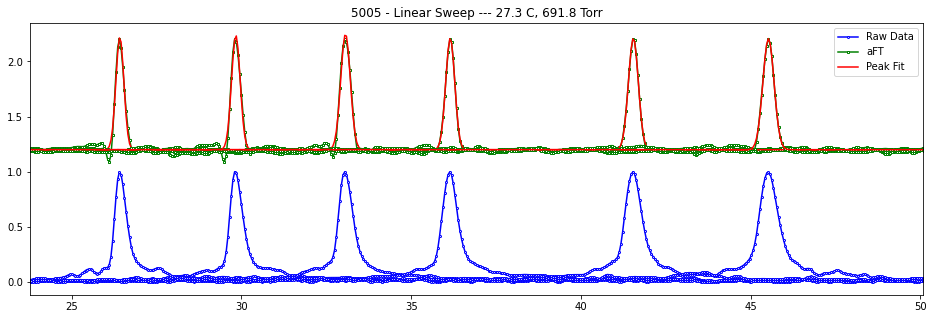

In [20]:
plt.figure()
peakctr_list = []
resultsList = []

for c, (key, val) in enumerate(mzRanges.items()):
    mz1, mz2 = val
#             print(mz1, mz2)
    mzCenter = (mz1+mz2)/2
    mzTol = mz2 - mzCenter

    xic_x, xic_y = getXIC(spectral_data, mzCenter, tol=mzTol)
    ft_x, ft_y = DFT_data(time= xic_x, amp= xic_y)


    #aFT_x and xic_x above should be the same vector, can optimize later
    aFT_x, aFT = DFT_aFT_data(time = xic_x, amp = xic_y, 
                              aFTBool = True, startFreq = startFreq, 
                              sweepRate = sweepRate, tOffset =aFTFactor)


    X = (ft_x[100:]/sweepRate) * 1000
    Y = ft_y[100:] #Exclude the large DC component that occurs follow FT of the IM data

    #normalizing the aFT to allow comparisons when plotting
    aFT = aFT[100:] #Exclude the large DC component that occurs follow FT of the IM data
    aYnorm, scaleFactor = normVector(aFT, retFactor=True)


    #peak fitting----------------------------------
    #This script requires peaks to be found, adjust to fit data set
    Ynorm, scaleFactor = normVector(Y, retFactor=True)
#     peakInds, junk = find_peaks(Ynorm, prominence=0.7) #fit on raw data
    peakInds, junk = find_peaks(aYnorm, prominence=0.7) #fit on aFT data

    #only one peak should be here,change as neeeded
    if len(peakInds) > 1:
        print('More than 1 peak found for {}-{}-#{}'.format(maxFreq, sweepType, fileNum))

    fwhm_est = peak_widths(Ynorm, peakInds, rel_height=0.5)
    width_est= np.diff(X).mean() * fwhm_est[0][0]

#     popt, pcov = curve_fit(gaussian, X, Ynorm, p0=[1, X[peakInds[-1]], width_est*2.35482]) #fit on raw data
    popt, pcov = curve_fit(gaussian, X, aYnorm, p0=[1, X[peakInds[-1]], width_est*2.35482])  #fit on aFT data

    amp = gaussian(X, *popt).max()
    ctr = popt[1]
    FWHM= (2.35482*popt[2])
    res_pwr = ctr / FWHM

    K0 = moCal(ctr, length=dtLength, voltage=dtVoltage, T=temp+273.15, P=press)


    peakctr_list.append(ctr)
    #plotting the raw data and fits----------------
    plt.plot(X, Ynorm, 'bo-', mfc='white', ms = 2, label='Raw Data' if c == 0 else '_nolegend_')
    
#     plt.plot(X, gaussian(X, *popt), 'r-', label='Peak Fit' if c == 0 else '_nolegend_')#plot fits to raw data
    plt.plot(X, aYnorm+1.2, 'gs-', mfc='white', ms = 2, label='aFT' if c == 0 else '_nolegend_')
    plt.plot(X, gaussian(X, *popt)+1.2, 'r-', label='Peak Fit' if c == 0 else '_nolegend_')#plot fits to aFT

    #consolidating the data to build df when done parsing finishes
    tempDict = {'Analyte': key,
                'SweepType': "Linear Sweep",
                'Max Freq' : maxFreq,
                'FWHM' : FWHM,
                'Centroid': ctr,
                'RP': res_pwr,
                'Intensity': amp,
                'Scale Factor' : scaleFactor,
                'Reduced Mobility': K0,
                'Length' : sweepTime}

    resultsList.append(tempDict)


#plot aesthetics
#xlim calc using percentages - +/- 10% usually looks good
cLo = min(peakctr_list)
cHi = max(peakctr_list)
xLo = cLo - (cLo * 0.10)
xHi = cHi + (cHi * 0.10)

plt.xlim(xLo, xHi)
plt.title('{} - {} --- {} C, {} Torr'.format(maxFreq, "Linear Sweep", temp, press))
plt.legend()

columns = ['Analyte', 'SweepType', 'Max Freq', 'FWHM', 'Centroid', 'RP', 'Intensity', 'Scale Factor',
       'Reduced Mobility', 'Length']

df = pd.DataFrame(resultsList, columns=columns)
DF = df.sort_values(by = ['Analyte', 'SweepType', 'Max Freq'], ignore_index=True)

### Display Data Frame
* Note: Resolving powers are for the raw peak fits or the aFT depending on the settings above
* Currently the Rp for the aFT is shown

In [19]:
DF

,Analyte,SweepType,Max Freq,FWHM,Centroid,RP,Intensity,Scale Factor,Reduced Mobility,Length
0,T10A,Linear Sweep,5005,0.344776,41.544679,120.497669,1.004366,745.976141,0.700440,430
1,T12A,Linear Sweep,5005,0.388861,45.524210,117.070778,1.006758,629.296221,0.639210,430
2,T5A,Linear Sweep,5005,0.278210,26.419092,94.960876,1.012630,246.494392,1.101459,430
3,T6A,Linear Sweep,5005,0.299561,29.835428,99.597274,1.030885,427.002195,0.975335,430
4,T7A,Linear Sweep,5005,0.333382,33.065437,99.181824,1.036271,650.917434,0.880059,430
5,T8A,Linear Sweep,5005,0.314292,36.150422,115.021872,1.005728,749.400937,0.804957,430
